# Use sktime to classify CTG scans using Apgar <7 as outcome

In [1]:
# Import required libraries
from dataclasses import dataclass
import matplotlib.pyplot as plt
import os
import pandas as pd
from sktime.transformations.panel.signature_based import SignatureTransformer

In [2]:
# Define file paths
@dataclass(frozen=True)
class Paths:
    '''Singleton object for storing paths to data and database.'''

    data = './data_csv'
    meta = 'metadata.csv'


paths = Paths()

## Load data

In [3]:
# Set up dictionary for CSV files
csv_files = dict()

# Load files into dictionary
filenames = os.listdir(paths.data)
for file in filenames:
    # Get filename and file extension
    filename, file_extension = os.path.splitext(os.path.join(paths.data, file))
    # Load data and save to dict with filename (without path/csv) as index
    if file_extension == '.csv':
        filename_short = filename.split('/')[-1]
        csv_files[filename_short] = pd.read_csv(os.path.join(paths.data, file))

In [4]:
# Load meta data and transform
metadata = pd.read_csv('./data_csv/metadata.csv', index_col='parameter')

## Preview the data

In [5]:
metadata.head()

,1347,2040,1054,1247,1127,1231,1318,1481,1358,1243,...,1421,1236,1256,1435,1404,1118,1018,1447,1152,1229
parameter,,,,,,,,,,,,,,,,,,,,,
pH,7.14,7.23,7.19,7.32,7.35,7.28,7.22,7.29,7.14,7.24,...,7.29,7.27,7.32,7.16,7.18,7.09,7.09,7.14,7.23,7.13
BDecf,8.60,5.27,4.45,-0.86,2.96,-0.06,5.86,2.50,6.52,1.77,...,5.76,5.92,4.73,7.01,7.35,8.76,9.58,7.91,0.16,6.21
pCO2,7.50,6.80,8.00,6.90,5.30,7.50,6.80,6.50,8.40,7.80,...,5.50,5.80,5.30,7.70,7.10,8.70,8.30,7.80,8.60,8.80
BE,-10.80,-7.00,-6.40,-1.00,-4.10,-1.80,-7.90,-4.10,-8.80,-4.10,...,-6.80,-7.40,-5.50,-8.00,-8.40,-11.70,-12.10,-9.80,-2.30,-8.90
Apgar1,10.00,2.00,9.00,9.00,9.00,8.00,5.00,8.00,5.00,10.00,...,9.00,9.00,9.00,9.00,3.00,8.00,8.00,10.00,8.00,9.00


In [6]:
# View example of first column
first = metadata.iloc[:, 0]
first

parameter
pH                    7.14
BDecf                 8.60
pCO2                  7.50
BE                  -10.80
Apgar1               10.00
Apgar5               10.00
NICU days             0.00
Seizures              0.00
HIE                   0.00
Intubation            0.00
Main diag.            0.00
Other diag.           0.00
Gest. weeks          40.00
Weight(g)          3190.00
Sex                   1.00
Age                  39.00
Gravidity             1.00
Parity                0.00
Diabetes              0.00
Hypertension          0.00
Preeclampsia          0.00
Liq.                  1.00
Pyrexia               0.00
Meconium              0.00
Presentation          1.00
Induced               1.00
I.stage             190.00
NoProgress            0.00
CK/KP                 0.00
II.stage             15.00
Deliv. type           1.00
dbID            1070958.00
Rec. type             1.00
Pos. II.st.       14400.00
Sig2Birth             0.00
Name: 1347, dtype: float64

In [7]:
# Get time series data for that first column
first_time = csv_files[first.name]
first_time.head()

,seconds,FHR,UC
0,0,128.50,21.5
1,1,128.00,21.5
2,2,128.00,21.5
3,3,127.25,21.5
4,4,127.25,21.0


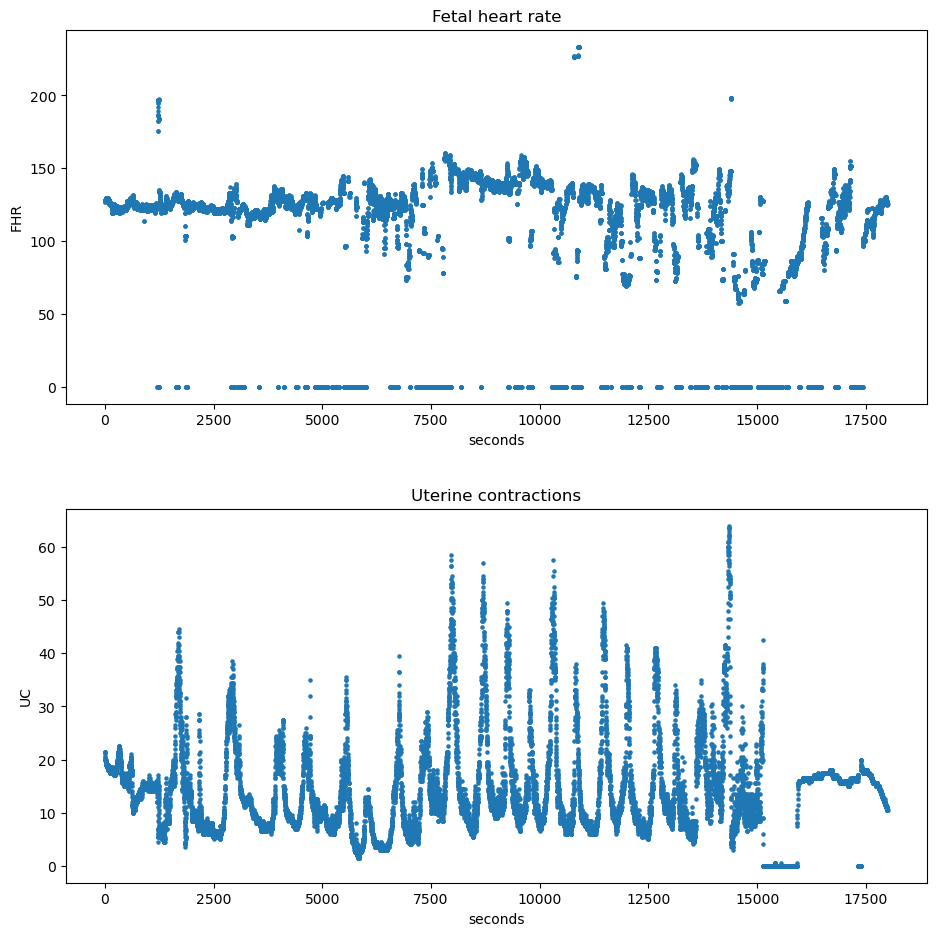

In [8]:
fig = plt.figure(figsize=(10,10))

# Plot fetal heart rate
ax1 = fig.add_subplot(2,1,1)
x = first_time['seconds']
y1 = first_time['FHR']
ax1.scatter(x, y1, s=5)
ax1.set_xlabel('seconds')
ax1.set_ylabel('FHR')
ax1.set_title('Fetal heart rate')

# Plot contractions
ax2 = fig.add_subplot(2,1,2)
x = first_time['seconds']
y2 = first_time['UC']
ax2.scatter(x, y2, s=5)
ax2.set_xlabel('seconds')
ax2.set_ylabel('UC')
ax2.set_title('Uterine contractions')

plt.tight_layout(pad=3)
plt.show()

Very imbalanced dataset - only 19 with apgar less than 7 (which indicates bad outcome).

In [9]:
(metadata.loc['Apgar5'] < 7).value_counts()

Apgar5
False    533
True      19
Name: count, dtype: int64

In [10]:
(metadata.loc['Apgar5'] < 7).value_counts(normalize=True)

Apgar5
False    0.96558
True     0.03442
Name: proportion, dtype: float64

## Signature transformer

In [11]:
signature_transform = SignatureTransformer(
    augmentation_list=("addtime",),
    window_name="global",
    window_depth=None,
    window_length=None,
    window_step=None,
    rescaling=None,
    sig_tfm="signature",
    depth=3,
)

ModuleNotFoundError: SignatureTransformer requires python version to be <3.10, but system python version is 3.10.13 (main, Sep 11 2023, 13:44:35) [GCC 11.2.0].